In [1]:
import pylab as pl
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
pl.rcParams['font.size']= 18.0


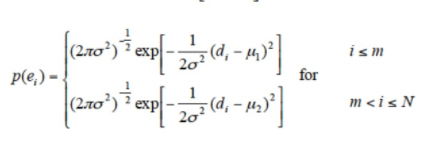

In [3]:
from IPython.core.display import Image, display
display(Image(
    'https://github.com/fedhere/UInotebooks/raw/master/pointifchange.png', 
    width=400, unconfined=True))


# generate synthetic data

In [6]:
timeSeries = np.hstack([np.random.randn(100), np.random.randn(100) + 3])

In [7]:
timeSeries.shape

(200,)

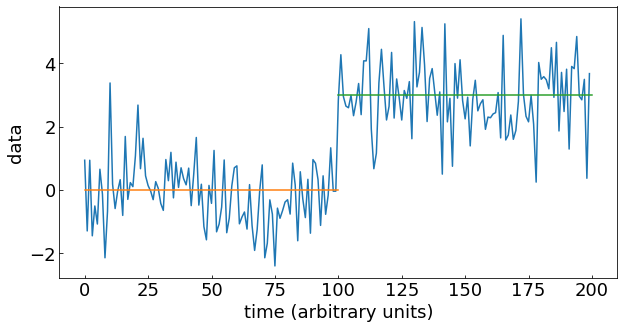

In [8]:
ax = pl.figure(figsize=(10,5)).add_subplot(111)
ax.plot(range(len(timeSeries)), timeSeries)
ax.plot([0,100], [0,0], '-')
ax.plot([100,200], [3,3], '-')
ax.set_ylabel("data")
ax.set_xlabel("time (arbitrary units)");

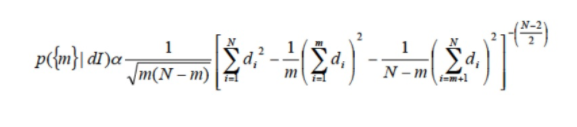

In [9]:
from IPython.core.display import Image, display
display(Image(
    'https://github.com/fedhere/UInotebooks/raw/master/pointifchangeIntegral.png', 
    width=600, unconfined=True))


In [10]:
##single point change detector
# as in https://www.slideshare.net/FrankKelly3/changepoint-detection-with-bayesian-inference
# with modifications for efficiency

def changeFinder(data):

    n = len(data)
    datamean = data.mean()
    datasqmean = (data**2).mean()
    fac = datasqmean - datamean**2
    
    datacsum = data.cumsum()
    datasum = datacsum[-1]

    ppoc = np.zeros(n) #container for point of change relative prob

    #online (iterative) search for point of change
    for m in range(n-1):
        pos = m + 1
        relativePosition = (pos) * (n - pos)
 
        Q = datacsum[m] - (datasum - datacsum[m]) #cumsum up to m - cumsum after
        
        U = -(datamean * (n - 2 * pos) + Q)**2 / (4.0 * relativePosition) + fac
       
        ppoc[m+1] = (-(n * 0.5 - 1) * np.log(n * U * 0.5) - 
                 0.5 * np.log(relativePosition))

    ppoc[0] = min(ppoc[1:])
    changePoint = np.argmax(ppoc)
    
    return {'pChange': ppoc, 
            'pointOfChange': changePoint + 1,
            'meanBefore': (data[:changePoint+1]).mean(), 
            'meanAfter': (data[(changePoint+1):]).mean()}



In [11]:
pochange = changeFinder(timeSeries)
pochange['pointOfChange']

101

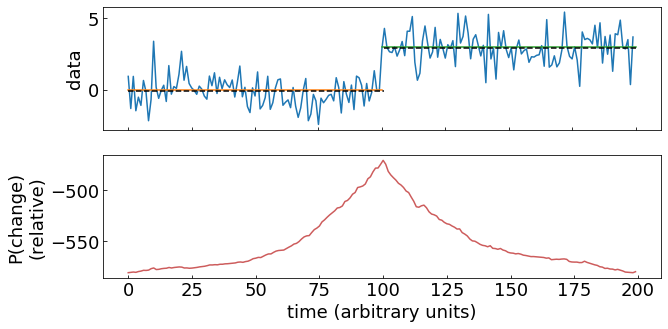

In [12]:
fig = pl.figure(figsize=(10,5))
ax1 = pl.subplot(211)
ax1.plot(range(len(timeSeries)), timeSeries)
ax1.plot([0,100], [0,0], '-')
ax1.plot([100,200], [3,3], '-')
ax1.set_xticklabels(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel("data")

ax2 = pl.subplot(212)
ax2.plot(range(len(timeSeries)), 
        pochange['pChange'], color="IndianRed")
ax1.plot([0,pochange['pointOfChange']], 
         [pochange['meanBefore'], pochange['meanBefore']], 'k--')
ax1.plot([pochange['pointOfChange'],len(timeSeries)], 
         [pochange['meanAfter'], pochange['meanAfter']], 'k--')
ax2.set_ylabel("P(change)\n(relative)")
ax2.set_xlabel("time (arbitrary units)");

In [13]:
import pandas as pd
lehd = pd.read_csv("qwi_7d09fc8c739345d7becf2e260a6d5977.csv",
                   index_col=0)
lehd.head()

,seasonadj,geo_level,geography,ind_level,industry,ownercode,sex,agegrp,race,ethnicity,education,firmage,firmsize,year,quarter,Emp,HirAEndR,sEmp,sHirAEndR,version
periodicity,,,,,,,,,,,,,,,,,,,,
Q,U,S,30,S,31-33,A00,0,A05,A0,A0,E0,0,0,1993,1,NaN,NaN,-1,-1,QWISA_F MT 30 1993:1-2017:1 V4.1.3 R2017Q4 qwi...
Q,U,S,30,S,31-33,A00,0,A05,A0,A0,E0,0,0,1993,2,6436.0,0.088,1,6,QWISA_F MT 30 1993:1-2017:1 V4.1.3 R2017Q4 qwi...
Q,U,S,30,S,31-33,A00,0,A05,A0,A0,E0,0,0,1993,3,6550.0,0.084,1,6,QWISA_F MT 30 1993:1-2017:1 V4.1.3 R2017Q4 qwi...
Q,U,S,30,S,31-33,A00,0,A05,A0,A0,E0,0,0,1993,4,6679.0,0.070,1,6,QWISA_F MT 30 1993:1-2017:1 V4.1.3 R2017Q4 qwi...
Q,U,S,30,S,31-33,A00,0,A05,A0,A0,E0,0,0,1994,1,6210.0,0.079,1,6,QWISA_F MT 30 1993:1-2017:1 V4.1.3 R2017Q4 qwi...


In [14]:
lehd.set_index(lehd["year"] + lehd["quarter"] * 0.25, inplace=True)
lehd.geography.unique()

array([30, 54, 42, 48, 45, 50, 49, 53,  2, 25,  1,  6, 21,  4,  5, 46, 47,
        8,  9, 28, 29, 40, 41, 51, 24, 56, 39, 26, 27, 20, 38, 11, 10, 13,
       12, 15, 22, 17, 16, 19, 18, 31, 23, 37, 36, 35, 34, 33, 55, 32, 44])

In [15]:
lehd.dropna(subset=["HirAEndR"], inplace=True)
lehd2 = lehd.groupby(lehd.index).mean()[["HirAEndR"]]
lehd2["stdev"] = lehd.groupby(lehd.index).std()["HirAEndR"]
lehd2.sort_index(inplace=True)
lehd2.head()

,HirAEndR,stdev
1990.50,0.069000,0.020224
1990.75,0.072667,0.018583
1991.00,0.069000,0.038626
1991.25,0.058000,0.024515
1991.50,0.066400,0.014046


In [16]:
pochange = changeFinder(lehd2.HirAEndR.values)
pochange['pointOfChange']

74

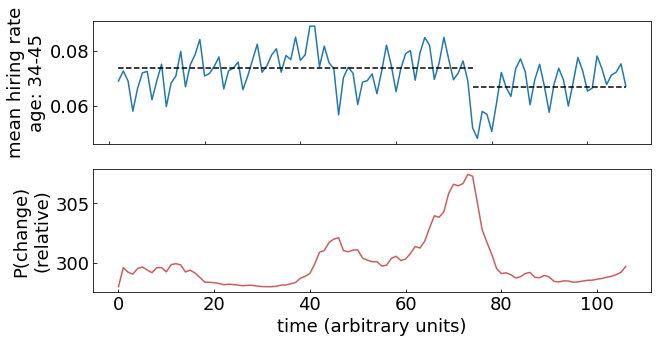

In [17]:
fig = pl.figure(figsize=(10,5))
ax1 = pl.subplot(211)
ax1.plot(lehd2.index.values, lehd2.HirAEndR.values)
ax1.set_xticklabels(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel("mean hiring rate\nage: 34-45")

ax2 = pl.subplot(212)
ax2.plot(range(len(lehd2)), 
        pochange['pChange'], color="IndianRed")
ax1.plot([lehd2.index.values.min(),lehd2.index.values[pochange['pointOfChange']]], 
         [pochange['meanBefore'], pochange['meanBefore']], 'k--')
ax1.plot([lehd2.index.values[pochange['pointOfChange']],
          lehd2.index.values.max()], 
         [pochange['meanAfter'], pochange['meanAfter']], 'k--')
ax2.set_ylabel("P(change)\n(relative)")
ax2.set_xlabel("time (arbitrary units)");

In [18]:
pochange['pChange'].argsort()[::-1]

array([ 73,  74,  72,  70,  71,  69,  75,  68,  66,  67,  65,  76,  46,
        45,  64,  44,  77,  62,  63,  50,  49,  43,  47,  48,  42,  61,
        78,  58,  51,  57,  60,  52,  59,  54,  53,  12,  41,  11,  13,
        56,  55, 106,   5,   9,   1,   8,  79,   4,   6,  15,  10,  14,
         2, 105,  86,   7,  81,  16,  40,  85,  80,   3, 104,  82,  89,
       103,  39,  84,  90, 102,  87,  17,  88,  83,  38, 101, 100,  99,
        98,  93,  94,  97,  91,  92,  96,  18,  19,  95,  37,  20,  21,
        36,  23,  24,  22,  35,  34,  25,  27,  28,  26,  29,  33,  30,
        31,  32,   0])

In [19]:
change2 = 46

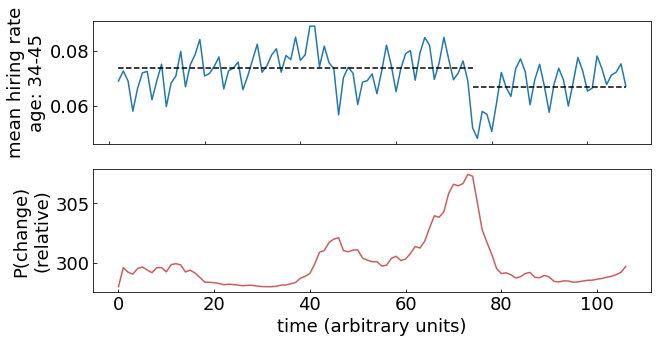

In [21]:
fig = pl.figure(figsize=(10,5))
ax1 = pl.subplot(211)
ax1.plot(lehd2.index.values, lehd2.HirAEndR.values)
ax1.set_xticklabels(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel("mean hiring rate\nage: 34-45")

ax2 = pl.subplot(212)
ax2.plot(range(len(lehd2)), 
        pochange['pChange'], color="IndianRed")

ax1.plot([lehd2.index.values.min(),
          lehd2.index.values[pochange['pointOfChange']]], 
         [pochange['meanBefore'], pochange['meanBefore']], 'k--')
ax1.plot([lehd2.index.values[pochange['pointOfChange']],
          lehd2.index.values.max()], 
         [pochange['meanAfter'], pochange['meanAfter']], 'k--')
ax2.set_ylabel("P(change)\n(relative)")
ax2.set_xlabel("time (arbitrary units)");